## Example 1: Understanding Weight Uncertainty
Let's start with something really simple - imagine we're trying to find the relationship between study hours and test scores. In a traditional neural network, we might say:

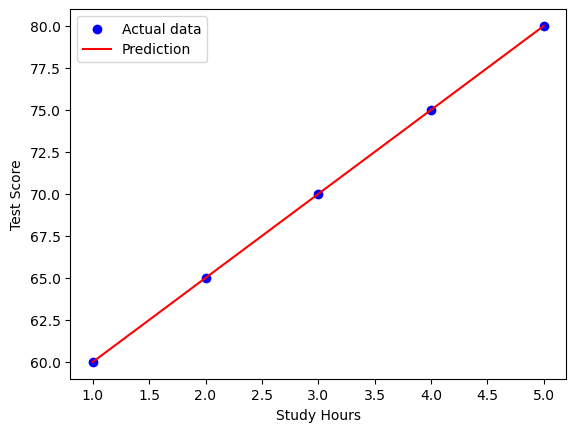

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Traditional Neural Network approach
study_hours = np.array([1, 2, 3, 4, 5])
test_scores = np.array([60, 65, 70, 75, 80])

# Single weight and bias
w = 5  # slope
b = 55  # intercept

prediction = w * study_hours + b

plt.scatter(study_hours, test_scores, color='blue', label='Actual data')
plt.plot(study_hours, prediction, color='red', label='Prediction')
plt.xlabel('Study Hours')
plt.ylabel('Test Score')
plt.legend()
plt.show()

Now, let's make this Bayesian! Instead of a single weight, we'll sample multiple possible weights:

In [2]:
def bayesian_predictions(x, num_samples =100):
  weights = np.random.normal(5, 1, num_samples)
  biases = np.random.normal(55, 2, num_samples)
  
  predictions = []
  for w, b in zip(weights, biases):
    pred = w * x + b 
    predictions.append(pred)
    
  return np.array(predictions)

study_hours = np.array([1,2,3,4,5])
predictions = bayesian_predictions(study_hours)


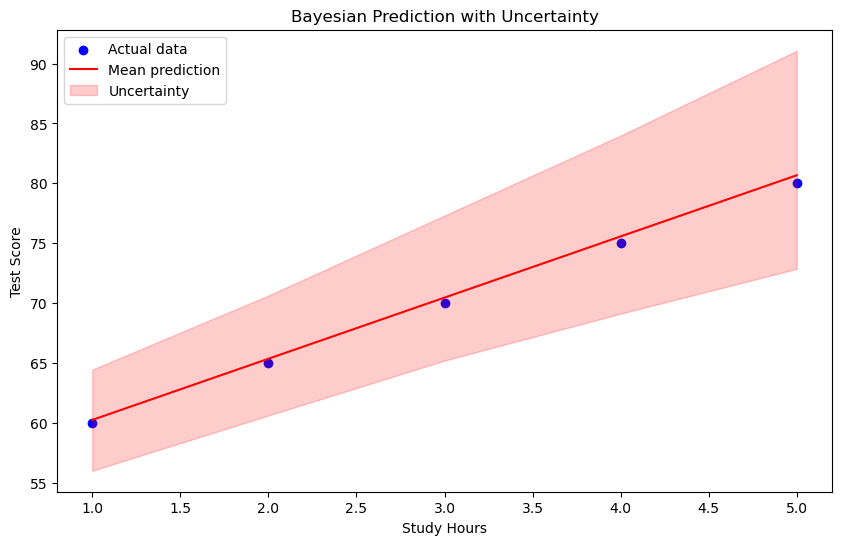

In [3]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(study_hours, test_scores, color='blue', label='Actual data')

# Plot mean prediction
mean_prediction = predictions.mean(axis=0)
plt.plot(study_hours, mean_prediction, color='red', label='Mean prediction')

# Plot uncertainty bands (95% confidence interval)
plt.fill_between(study_hours, 
                 np.percentile(predictions, 2.5, axis=0),
                 np.percentile(predictions, 97.5, axis=0),
                 alpha=0.2, color='red',
                 label='Uncertainty')

plt.xlabel('Study Hours')
plt.ylabel('Test Score')
plt.legend()
plt.title('Bayesian Prediction with Uncertainty')
plt.show()

This gives us a visualization of the uncertainty in our predictions! The shaded area shows where we think the true values might lie.

## Example 2: Let's Build a Simple BNN Layer
Now, let's create a very simple Bayesian neural network layer using PyTorch:

In [8]:
import torch
import torch.nn as nn

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # We need two sets of parameters for our Bayesian layer:
        # 1. Mean parameters (what we believe the weights/biases should be on average)
        # 2. Variance parameters (how uncertain we are about these weights/biases)
        
        # Weight parameters - initialized slightly away from zero to help learning
        self.weight_mu = nn.Parameter(torch.randn(in_features, out_features) * 0.1)
        self.weight_log_var = nn.Parameter(torch.zeros(in_features, out_features))
        
        # Bias parameters - initialized to help match your output scale
        self.bias_mu = nn.Parameter(torch.zeros(out_features) + 70.0)  # Center near data mean
        self.bias_log_var = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        # During forward pass, we sample weights and biases from their distributions
        # This is the core of what makes the network Bayesian
        weight = self.weight_mu + torch.exp(0.5 * self.weight_log_var) * torch.randn_like(self.weight_mu)
        bias = self.bias_mu + torch.exp(0.5 * self.bias_log_var) * torch.randn_like(self.bias_mu)
        
        return torch.matmul(x, weight) + bias

class SimpleBNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.bnn_layer = BayesianLinear(1, 1)

    def forward(self, x):
        return self.bnn_layer(x)

In [9]:
# Convert data to PyTorch tensors
X = torch.FloatTensor(study_hours).reshape(-1, 1)
y = torch.FloatTensor(test_scores).reshape(-1, 1)

# Create model and optimizer
model = SimpleBNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)




In [16]:
# Training loop
for epoch in range(3000):
    optimizer.zero_grad()
    
    # Make multiple predictions to capture uncertainty
    predictions = torch.stack([model(X) for _ in range(10)])
    
    # Calculate loss - combination of prediction error and model complexity
    mse_loss = torch.mean((predictions.mean(0) - y) ** 2)
    kl_loss = 0.05 * (torch.sum(torch.exp(model.bnn_layer.weight_log_var)) + 
                      torch.sum(model.bnn_layer.weight_mu ** 2))
    
    loss = mse_loss + kl_loss
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, MSE: {mse_loss.item():.4f}')

# Generate predictions with uncertainty
with torch.no_grad():
    # Make multiple predictions to estimate uncertainty
    predictions = torch.stack([model(X) for _ in range(100)])
    mean_pred = predictions.mean(0)
    std_pred = predictions.std(0)

Epoch 0, Loss: 1.2538, MSE: 0.1186
Epoch 100, Loss: 1.2221, MSE: 0.0287
Epoch 200, Loss: 1.2177, MSE: 0.0290
Epoch 300, Loss: 1.2228, MSE: 0.0331
Epoch 400, Loss: 1.2186, MSE: 0.0312
Epoch 500, Loss: 1.2215, MSE: 0.0314
Epoch 600, Loss: 1.2231, MSE: 0.0312
Epoch 700, Loss: 1.2184, MSE: 0.0277
Epoch 800, Loss: 1.2218, MSE: 0.0300
Epoch 900, Loss: 1.2188, MSE: 0.0270
Epoch 1000, Loss: 1.2167, MSE: 0.0272
Epoch 1100, Loss: 1.2207, MSE: 0.0330
Epoch 1200, Loss: 1.2234, MSE: 0.0350
Epoch 1300, Loss: 1.2179, MSE: 0.0288
Epoch 1400, Loss: 1.2177, MSE: 0.0278
Epoch 1500, Loss: 1.2156, MSE: 0.0273
Epoch 1600, Loss: 1.2169, MSE: 0.0273
Epoch 1700, Loss: 1.2168, MSE: 0.0266
Epoch 1800, Loss: 1.2181, MSE: 0.0277
Epoch 1900, Loss: 1.2188, MSE: 0.0286
Epoch 2000, Loss: 1.2178, MSE: 0.0277
Epoch 2100, Loss: 1.2172, MSE: 0.0260
Epoch 2200, Loss: 1.2174, MSE: 0.0289
Epoch 2300, Loss: 1.2200, MSE: 0.0288
Epoch 2400, Loss: 1.2155, MSE: 0.0283
Epoch 2500, Loss: 1.2218, MSE: 0.0330
Epoch 2600, Loss: 1.2155

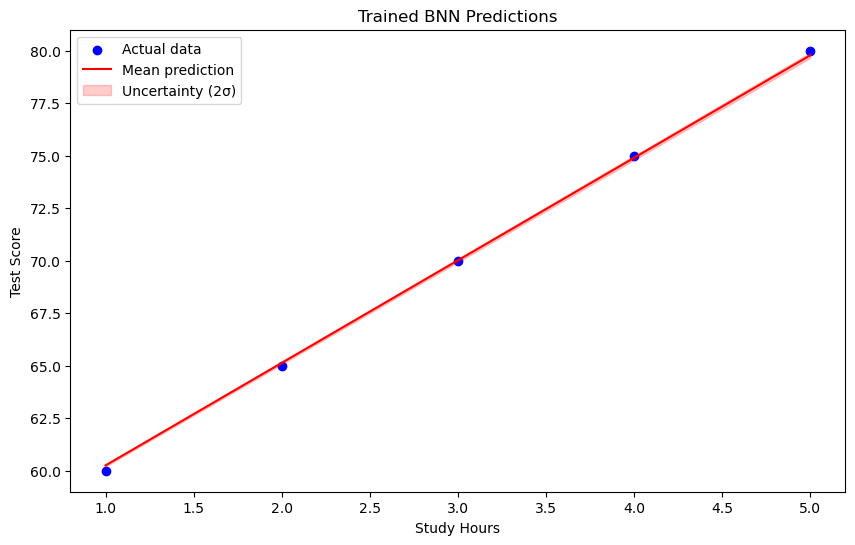

In [17]:

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(study_hours, test_scores, color='blue', label='Actual data')
plt.plot(study_hours, mean_pred.numpy(), color='red', label='Mean prediction')
plt.fill_between(study_hours, 
                 (mean_pred - 2*std_pred).numpy().flatten(),
                 (mean_pred + 2*std_pred).numpy().flatten(),
                 alpha=0.2, color='red', 
                 label='Uncertainty (2σ)')
plt.xlabel('Study Hours')
plt.ylabel('Test Score')
plt.legend()
plt.title('Trained BNN Predictions')
plt.show()